## Descriptions:
Imputation of missing ESI and HW
- Impute HW using some demographics variables
- Get first values of vital signs to impute ESI

**Inputs**:  
- `cohort_demoHW` contains all processed variables in demographics (including ESI) and height and weight
- `flowsheet` contrains vital signs


**Outputs**: 
* `cohort_imputed_ESIHW` 

### Importing R libraries

In [1]:
library(bigrquery)  # to query STARR-OMOP (stored in BigQuery) using SQL
library(tidyverse)
library(lubridate)
library(mice)
library(VIM) # for missing data plot

# library(data.table)
# library(Matrix)
# library(caret) # import this before glmnet to avoid rlang version problem
# library(glmnet)
# library(bit64)

# library(slam)
# library(mtools) for one hot coder, not available on Nero or use caret or tidyr
options(repr.matrix.max.rows=250, repr.matrix.max.cols=30)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind




In [11]:
# read inputs
datadir = "../../DataTD"
featuredir = "../../OutputTD/2_features"

cohort <- read.csv(file.path(featuredir, "cohort_demoHW.csv"))

# check for unique CSNs and MRNs
nrow(cohort) #45796
nrow(cohort %>% select(anon_id) %>% distinct()) #31513
nrow(cohort %>% select(pat_enc_csn_id_coded) %>% distinct()) #31513
nrow(cohort %>% select(anon_id, pat_enc_csn_id_coded) %>% distinct()) #31513

colnames(cohort)

[1] 45796

[1] 31513

[1] 45796

[1] 45796

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "label"                   "admit_time"             
 [5] "inpatient_data_id_coded" "ESI"                    
 [7] "gender"                  "race"                   
 [9] "insurance"               "age"                    
[11] "English"                 "Height"                 
[13] "Weight"

### Imputation for Height and Weight 
- Using just the demographics' variables: gender, race, age, insurance, Height, Weight
- Output: keep imputed height and weight, and add indicators for missingness
- Could use mice, however, simpler approach just use pmm method for 1 single imputation
- Use m=10 (m=5 is ok) as dataset is large and we end up only get 1 imputed dataset
- https://statisticalhorizons.com/predictive-mean-matching

,gender,race,age,insurance,Weight,Height,
44337,1,1,1,1,1,1,0
1147,1,1,1,1,1,0,1
36,1,1,1,1,0,1,1
276,1,1,1,1,0,0,2
,0,0,0,0,312,1423,1735



 iter imp variable
  1   1  Height  Weight
  1   2  Height  Weight
  1   3  Height  Weight
  1   4  Height  Weight
  1   5  Height  Weight
  1   6  Height  Weight
  1   7  Height  Weight
  1   8  Height  Weight
  1   9  Height  Weight
  1   10  Height  Weight
  2   1  Height  Weight
  2   2  Height  Weight
  2   3  Height  Weight
  2   4  Height  Weight
  2   5  Height  Weight
  2   6  Height  Weight
  2   7  Height  Weight
  2   8  Height  Weight
  2   9  Height  Weight
  2   10  Height  Weight
  3   1  Height  Weight
  3   2  Height  Weight
  3   3  Height  Weight
  3   4  Height  Weight
  3   5  Height  Weight
  3   6  Height  Weight
  3   7  Height  Weight
  3   8  Height  Weight
  3   9  Height  Weight
  3   10  Height  Weight
  4   1  Height  Weight
  4   2  Height  Weight
  4   3  Height  Weight
  4   4  Height  Weight
  4   5  Height  Weight
  4   6  Height  Weight
  4   7  Height  Weight
  4   8  Height  Weight
  4   9  Height  Weight
  4   10  Height  Weight
  5   1  Height 

Warning message:
“Number of logged events: 2”


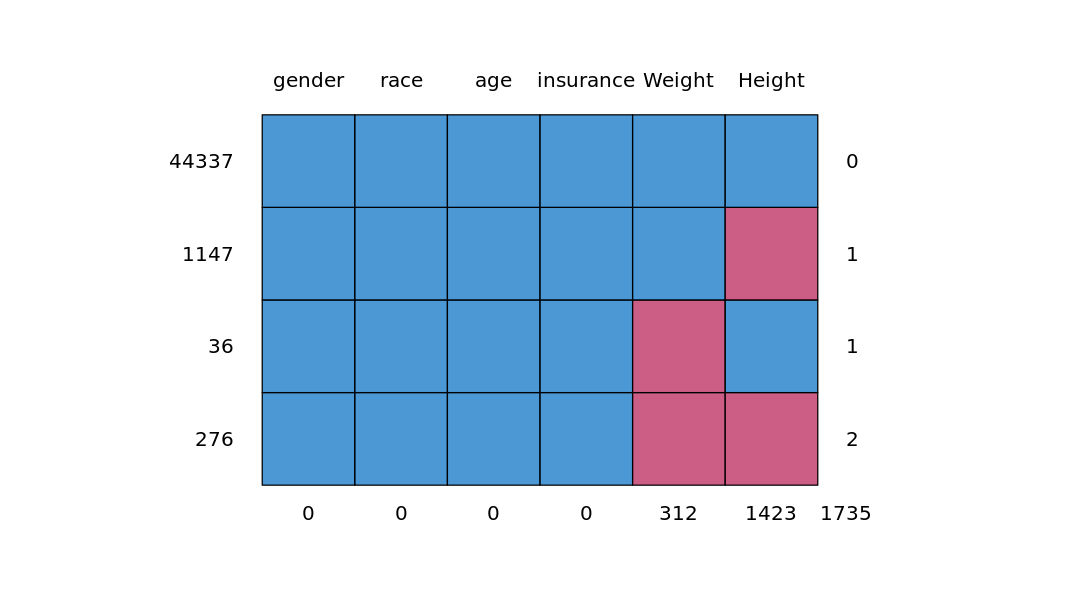

In [32]:
# this takes awhile(~2min), set seed = 123
# only impute 3 time, predictive mean matching

cohort_hw <- cohort %>% select(gender, race, age, insurance, Height, Weight)

md.pattern(cohort_hw)
hw_mice <- mice(cohort_hw, m=10, maxit=50, meth='pmm', seed=123)

Warning message in plot.aggr(res, ...):
“not enough horizontal space to display frequencies”



 Variables sorted by number of missings: 
  Variable       Count
    Height 0.031072583
    Weight 0.006812822
    gender 0.000000000
      race 0.000000000
       age 0.000000000
 insurance 0.000000000


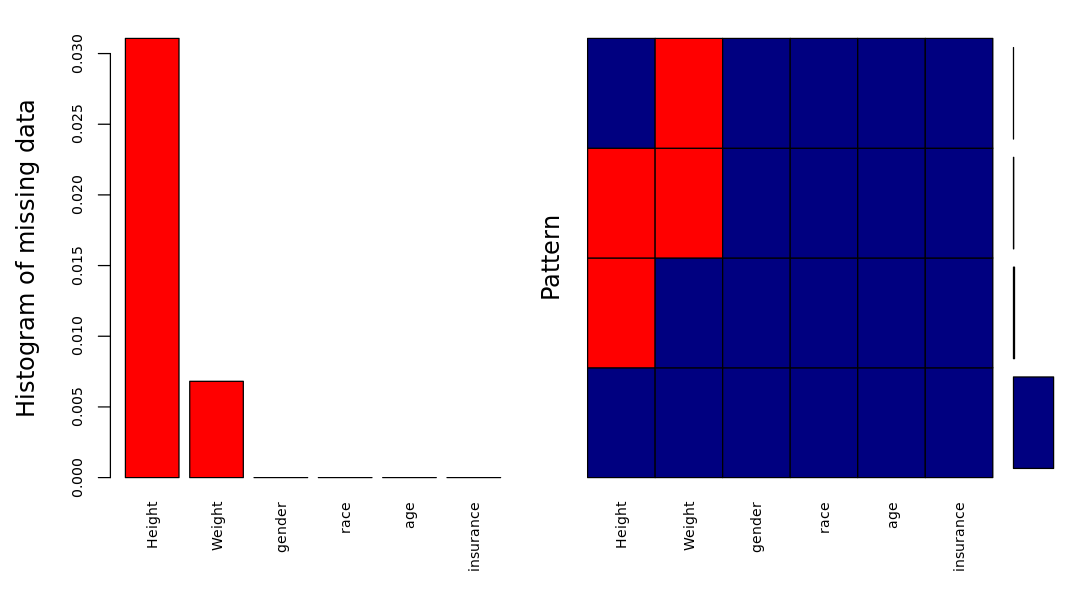

In [50]:
options(repr.plot.width=9, repr.plot.height=5)
aggr_plot <- aggr(cohort_hw, col=c('navyblue','red'), numbers=TRUE, sortVars=TRUE, 
                  labels=names(cohort_hw), cex.axis=.7, gap=3, ylab=c("Histogram of missing data","Pattern"))

In [33]:
# note: no pooling of results from analysis of multiply imputed dataset
# chose the 2nd set. can also do a random number each time

hw_mice2 <- complete(hw_mice, 2)
summary(hw_mice2)
colnames(hw_mice2)

    gender              race                age          insurance     
 Length:45796       Length:45796       Min.   :18.00   Min.   :0.0000  
 Class :character   Class :character   1st Qu.:44.00   1st Qu.:0.0000  
 Mode  :character   Mode  :character   Median :60.00   Median :0.0000  
                                       Mean   :58.28   Mean   :0.4192  
                                       3rd Qu.:73.00   3rd Qu.:1.0000  
                                       Max.   :90.00   Max.   :1.0000  
     Height          Weight      
 Min.   :115.0   Min.   : 20.50  
 1st Qu.:160.0   1st Qu.: 61.00  
 Median :168.0   Median : 73.30  
 Mean   :168.2   Mean   : 76.92  
 3rd Qu.:175.3   3rd Qu.: 88.00  
 Max.   :213.0   Max.   :320.69  

[1] "gender"    "race"      "age"       "insurance" "Height"    "Weight"

In [34]:
nrow(hw_mice2) #45796

# here: keep bind the old set with the imputed set, just to compare
hw_mice2name <- hw_mice2 %>% select(Height, Weight) %>% 
                    rename(Height_i = Height, Weight_i = Weight)

cohort_HWimputed2 <- bind_cols(cohort, hw_mice2name) 
colnames(cohort_HWimputed2)

[1] 45796

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "label"                   "admit_time"             
 [5] "inpatient_data_id_coded" "ESI"                    
 [7] "gender"                  "race"                   
 [9] "insurance"               "age"                    
[11] "English"                 "Height"                 
[13] "Weight"                  "Height_i"               
[15] "Weight_i"

In [35]:
head(cohort_HWimputed2, n=1)

,anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,gender,race,insurance,age,English,Height,Weight,Height_i,Weight_i
,<chr>,<dbl>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,JC29f8ad2,131274729058,0,2019-08-31 12:52:00,40679773,3,Female,White,1,52,1,165,81,165,81


In [36]:
# 2 = we have both the original values and the imputed values in this same dataset, 
# but it doesn't have the indicators of missingness
cohort_HWimputed2 <- cohort_HWimputed2 %>% 
                        select(c(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, label, admit_time, ESI, 
                                 gender, race, age, insurance, English, Height, Height_i, Weight, Weight_i))

In [37]:
# only keep the imputed versions of Height and Weight and add indicators
cohort_HWimputed <- cohort_HWimputed2 %>% 
                        mutate(delta_H = ifelse(is.na(Height), 1, 0),
                               delta_W = ifelse(is.na(Weight), 1, 0)) %>%
                        select(-c(Height, Weight))

summary(cohort_HWimputed %>% select(delta_H, delta_W))
colnames(cohort_HWimputed)

    delta_H           delta_W        
 Min.   :0.00000   Min.   :0.000000  
 1st Qu.:0.00000   1st Qu.:0.000000  
 Median :0.00000   Median :0.000000  
 Mean   :0.03107   Mean   :0.006813  
 3rd Qu.:0.00000   3rd Qu.:0.000000  
 Max.   :1.00000   Max.   :1.000000  

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "inpatient_data_id_coded" "label"                  
 [5] "admit_time"              "ESI"                    
 [7] "gender"                  "race"                   
 [9] "age"                     "insurance"              
[11] "English"                 "Height_i"               
[13] "Weight_i"                "delta_H"                
[15] "delta_W"

### Imputation for ESI
ESI -- from acuity_level encounter table
- use first vital values from vitals_clean to impute ESI
- this require the vitals_clean dataset to be done
- before: use cohort with at least 1 vs --> change: use cohort with a complete set of vs --> simple and complex models
- vs1st_complete.csv is already updated

[1] 45796

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  1.000   2.000   3.000   2.654   3.000   5.000    1861 

$gender

Female   Male 
 21898  23898 

$race

           Asian            Black  Native American            Other 
            6871             3260              195            10510 
Pacific Islander          Unknown            White 
             930              424            23606 


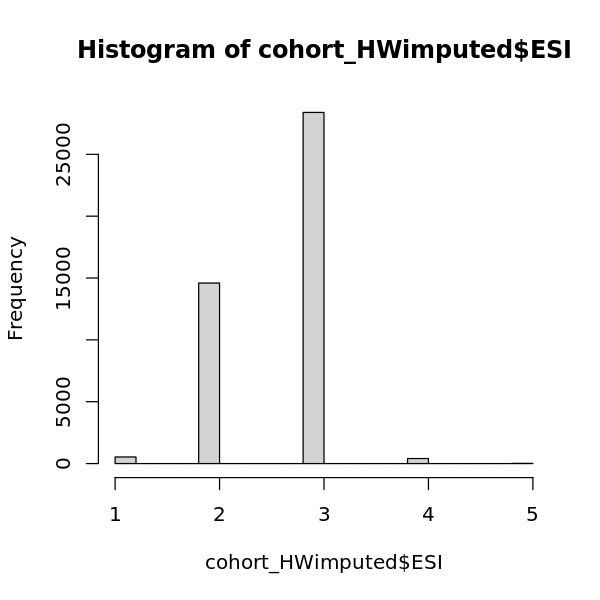

In [52]:
# missing ESI: 1861 (4.06%)
options(repr.plot.width=5, repr.plot.height=5)

nrow(cohort_HWimputed)
summary(cohort_HWimputed$ESI)
apply(cohort_HWimputed[c("gender", "race")], 2, table)
hist(cohort_HWimputed$ESI)

In [53]:
# missing ESI per label
cohort %>% group_by(ESI, label) %>% count() %>% group_by(ESI) %>% mutate(p = round(100* n/sum(n), 2))

ESI,label,n,p
<int>,<int>,<int>,<dbl>
1,0,122,22.85
1,1,412,77.15
2,0,11499,78.80
2,1,3094,21.20
3,0,26403,93.01
3,1,1983,6.99
4,0,366,90.15
4,1,40,9.85
5,0,15,93.75


#### NEED vs1st_complete dataset, get from vitals notebook

In [ ]:
# use the vs1st_complete.csv --> 41654, better cohort for imputation
# if use vs1st.csv with GCS we have 43320, but remove these so only 43291
vs1st <- read.csv(file.path(datadir, "vs1st.csv"))

# vs1st <- read.csv(file.path(datadir, "vs1st_complete.csv"))
nrow(vs1st)

# this demo is not the same demo read from demographics, same as cohort_demo_imputed as above
demo <- read.csv(file.path(datadir, "cohort_demo_imputedHW.csv"))
nrow(demo)

In [ ]:
# vs1wide <- vs1st %>% spread(features, first_val) %>% select(-GCS) # then need to filter out all NA as below
# vs1wide <- vs1wide %>% filter_at(vars(DBP, Pulse, RR, SBP, SpO2, Temp), any_vars(!is.na(.)))

# remove GCS (not many), and turn wide format for imputation
vs1wide <- vs1st %>% filter(features != "GCS") %>% spread(features, first_val)
head(vs1wide)
nrow(vs1wide) # 43291 --> now 41654 for complete set of VS with final cohort
nrow(vs1wide %>% filter_all(all_vars(is.na(.)))) # number of rows that have all NA
nrow(vs1wide %>% drop_na()) # number of rows that have no NA (complete cases) accross all cols

In [ ]:
colnames(demo)

In [ ]:
vs1demo <- left_join(vs1wide, demo)
nrow(vs1demo)
head(vs1demo)
colnames(vs1demo)

In [ ]:
summary(vs1demo) # missing 1665 ESI

In [ ]:
# this chunk takes a while (~ 5min)
# m refers to the number of imputed datasets. Five is the default --> takes too long
# meth='pmm' refers to the imputation method, predictive mean matching
# complete(, returns the 2nd completed data set)
vs1demo_imp <- vs1demo %>% select(ESI, gender, race, age, medis, Height_i, Weight_i, SBP, DBP, Pulse, RR, SpO2, Temp)

md.pattern(vs1demo_imp)
vs1demo_mice <- mice(vs1demo_imp, m=3, maxit=50, meth='pmm', seed=123)
vs1demo_imp2 <- complete(vs1demo_mice, 2)

In [ ]:
summary(vs1demo_imp2)

In [ ]:
# rename the imputed variables from the imputed data set with an added _i
# not doing this: SBP_i=SBP, DBP_i=DBP, Pulse_i=Pulse, RR_i=RR, SpO2_i=SpO2, Temp_i=Temp
vs1demo_imp_name <- vs1demo_imp2 %>% select(ESI_i=ESI) 

# bind the imputed ESI with the original data and add a missing indicator for ESI
vs1demo_all <- bind_cols(vs1demo, vs1demo_imp_name) %>% mutate(delta_ESI = ifelse(is.na(ESI), 1, 0))
colnames(vs1demo_all)

In [ ]:
dim(vs1demo_all)
head(vs1demo_all %>% filter(delta_ESI ==1))

In [ ]:
# rearrange all the columns 
cohort_demo <- vs1demo_all %>% select(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, label_max24, admit_time, 
                                      ESI_i, delta_ESI, gender, race, age, medis, English,  
                                      Height_i, delta_H, Weight_i, delta_W,
                                      SBP, DBP, Pulse, RR, SpO2, Temp)
dim(cohort_demo)

### One hot coding for gender and race
* Gender: simply 1 for female and 0 for male
* Race: one-hot coding as usual

In [ ]:
# 1 for female and 0 for male:
cohort_demo <- cohort_demo %>% mutate(gender = ifelse(gender == "Male", 0, 1),
                                      race =  as.factor(race))
summary(cohort_demo %>% select(gender, race))

In [ ]:
# onehot coding for race:
dummy <- dummyVars(~ race, data = cohort_demo) # if more ! gender + race
race_1hot <- data.frame(predict(dummy, newdata = cohort_demo))
cohort_demo <-  cohort_demo %>% select(-race) %>% bind_cols(race_1hot)
ncol(cohort_demo)

In [ ]:
summary(cohort_demo)

In [ ]:
nrow(cohort_demo)
head(cohort_demo, n=3)

In [ ]:
# save file: all ESI (and first_val of vital signs imputed)
write.csv(cohort_demo, file.path(datadir, "cohort_demo_final.csv"), row.names=FALSE)

# this is the correct new cohort with at least one component of vital signs
# cohort_has_vs <- cohort_demo %>% select(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, label_max24, admit_time)

# nrow(cohort_has_vs)
# write.csv(cohort_has_vs, file.path(datadir, "cohort_has_vs.csv"), row.names=FALSE)

### Get the dataset for simple models:
A cohort with complete set of VS, with labels (43008 --> 41654), with the following features
* get back the demographics (with imputed ESI using 1st set of vs)
* vital signs (first values and summary statistics) only (no GCS)

In [ ]:
vsum_wide <- read.csv(file.path(datadir, 'vitalsum_wide.csv'))
nrow(vsum_wide)

In [ ]:
demos <- read.csv(file.path(datadir, "cohort_demo_final.csv"))
nrow(demos)
colnames(demos)

In [ ]:
# add demographic features to this data with vital signs
demos <- demos %>% select(-c(inpatient_data_id_coded, label_max24, admit_time))
data_simple <- left_join(vsum_wide, demos)
dim(data_simple)
nrow(data_simple %>% select(pat_enc_csn_id_coded) %>% distinct())
colnames(data_simple)
summary(data_simple)

In [ ]:
# update cohort with labels to include only patients with a complete set of VS
# cohort <- read.csv("./Data/cohort_labels.csv")
cohort <- read.csv(file.path(datadir, "labels_with_death_delta.csv")) 

dim(cohort)
tail(cohort, 10)

In [ ]:
cohort_final <- data_simple %>% select(anon_id, pat_enc_csn_id_coded) %>% left_join(cohort) #%>%
#                 select(-c(int64_field_0))

dim(cohort_final)
head(cohort_final, n=1)

In [ ]:
colnames(cohort_final)
summary(cohort_final)

In [ ]:
# updata data simple to include labels:
data_simple <- left_join(cohort_final, data_simple)
dim(data_simple)
colnames(data_simple)

In [ ]:
# need to check the label

In [ ]:
# write.csv(cohort_final, file.path(datadir, 'cohort_final.csv'), row.names = FALSE)
# write.csv(data_simple, file.path(datadir, "data_simple.csv"), row.names=FALSE)

### EXTRA

In [ ]:
# did not miss any BP
added_vs <- read.csv(file.path(datadir, "added_vs.csv"))
nrow(added_vs)
added_vs %>% count(row_disp_name)
head(added_vs)